### Kuramoto Sivashinsky (regular) equation in JAX

$\begin{aligned}
    &u_t + \alpha uu_x + \beta u_{xx} + \gamma u_{xxxx} = 0 \\
    &\alpha = 5, \beta = 0.5, \gamma = 0.005 \\
    &u_0(x) = -\sin (\pi x) 
\end{aligned}$

In [2]:
import jax 
import jax.numpy as jnp
from jax.experimental.jet import jet
import numpy as np
import flax
from flax import linen as nn
from flax.training import train_state
from flax.training.early_stopping import EarlyStopping
import optax
import scipy
import matplotlib.pyplot as plt
import pickle
import copy
import time
from tqdm import trange
from typing import Sequence
from functools import partial

import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [3]:
M = 5
L = 2.0
layer_sizes_u = [2*M+1] + [256] * 3 + [1] # output u_{n+1}
layer_sizes_k = [2*M+1] + [256] * 3 + [2] # output k1, k2

class Net(nn.Module):
    layer_sizes: Sequence[int]
    M: int
    L: float
        
    def setup(self):
        self.W1 = nn.Dense(features=self.layer_sizes[1], kernel_init=nn.initializers.xavier_normal(), bias_init=nn.initializers.zeros_init())
        self.W2 = nn.Dense(features=self.layer_sizes[1], kernel_init=nn.initializers.xavier_normal(), bias_init=nn.initializers.zeros_init())
        self.Wz = [nn.Dense(features=size, kernel_init=nn.initializers.xavier_normal(), bias_init=nn.initializers.zeros_init()) for size in self.layer_sizes[1:]]

    def input_encoding(self, x):
        w = 2 * jnp.pi / self.L
        k = jnp.arange(1, self.M + 1)
        return jnp.hstack([jnp.ones(x.shape), jnp.cos(k*w*x), jnp.sin(k*w*x)])

    def __call__(self, x):
        X = self.input_encoding(x)
        U = nn.tanh(self.W1(X))
        V = nn.tanh(self.W2(X))

        H = nn.tanh(self.Wz[0](X))
        for linear in self.Wz[1:-1]:
            Z = nn.tanh(linear(H))
            H = jnp.multiply(1 - Z, U) + jnp.multiply(Z, V)
        return self.Wz[-1](H)

net_u = Net(layer_sizes_u, M, L)
net_k = Net(layer_sizes_k, M, L)

In [4]:
def mse_fn(true, pred):
    return jnp.mean(jnp.square(true - pred))

def diff(func, argnums):
    return jax.grad(lambda *ar, **kw: jnp.sum(func(*ar, **kw)), argnums=argnums)

@jax.jit
def train_step_u0(state_u, x_r, x_du0, u_true, du_true):
    def loss_fn(params):
        u_fn = lambda x: state_u.apply_fn(params, x)
        du_x = diff(u_fn, 0)
        loss_f = 10000*mse_fn(u_true, u_fn(x_r))
        loss_d = mse_fn(du_true, du_x(x_du0))
        
        loss = loss_f + loss_d
        return loss, (loss_f, loss_d)
    grads, (loss_f, loss_d) = jax.grad(loss_fn, argnums=0, has_aux=True)(state_u.params)
    state_u = state_u.apply_gradients(grads=grads)
    return state_u, loss_f, loss_d

@jax.jit
def train_step_rest(state_u, state_k, x, uk, duk_x, duk_xx, duk_xxx, duk_xxxx, N_t):
    h = 1/N_t
    p1 = h/4
    q1 = (1/4 + jnp.sqrt(3)/6)*h
    p2 = (1/4 - jnp.sqrt(3)/6)*h
    q2 = h/4

    def loss_u_fn(params_u, fk1, fk2):
        u_fn  = lambda x: state_u.apply_fn(params_u, x)
        u = u_fn(x)
        
        loss_r = mse_fn((u-uk)/h, (fk1+fk2)/2)
        return loss_r, loss_r
    
    def loss_k_fn(params_k):
        k1_fn = lambda x: state_k.apply_fn(params_k, x)[:,0:1]
        k2_fn = lambda x: state_k.apply_fn(params_k, x)[:,1:2]

        k1, (dk1_x, dk1_xx, dk1_xxx, dk1_xxxx) = jet(k1_fn, (x, ), [[1.0, 0.0, 0.0, 0.0]]) #  Taylor-mode AD
        k2, (dk2_x, dk2_xx, dk2_xxx, dk2_xxxx) = jet(k2_fn, (x, ), [[1.0, 0.0, 0.0, 0.0]]) #  Taylor-mode AD

        fk1 = -5*(uk+p1*k1+q1*k2)*(duk_x+p1*dk1_x+q1*dk2_x) - 0.5*(duk_xx+p1*dk1_xx+q1*dk2_xx) - 0.005*(duk_xxxx+p1*dk1_xxxx+q1*dk2_xxxx)
        fk2 = -5*(uk+p2*k1+q2*k2)*(duk_x+p2*dk1_x+q2*dk2_x) - 0.5*(duk_xx+p2*dk1_xx+q2*dk2_xx) - 0.005*(duk_xxxx+p2*dk1_xxxx+q2*dk2_xxxx)

        loss_k1 = mse_fn(fk1, k1)
        loss_k2 = mse_fn(fk2, k2)

        loss_k = loss_k1 + loss_k2 
        return loss_k, (loss_k1, loss_k2, fk1, fk2)

    grads_k, (loss_k1, loss_k2, fk1, fk2) = jax.grad(loss_k_fn, argnums=0, has_aux=True)(state_k.params)
    grads_u, loss_r = jax.grad(loss_u_fn, argnums=0, has_aux=True)(state_u.params, fk1, fk2)
    
    state_k = state_k.apply_gradients(grads=grads_k)
    state_u = state_u.apply_gradients(grads=grads_u)
    return state_u, state_k, loss_k1, loss_k2, loss_r

In [5]:
# u(x, 0)
def U_x0(x):
    return -jnp.sin(jnp.pi*x)

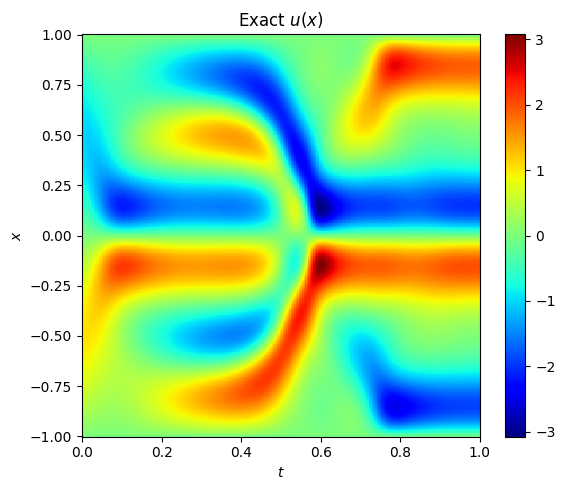

In [6]:
dtdt = 1
N_t = 250*dtdt
N_x = 512
key = jax.random.PRNGKey(2023)
key, skey = jax.random.split(key)
dummy_x = jax.random.uniform(skey, (N_x, 1))
key, skey = jax.random.split(skey)
params_u = net_u.init(skey, dummy_x)
params_k = net_k.init(skey, dummy_x)

# Load the data and grid
data = scipy.io.loadmat('ks_simple.mat')
usol = data['usol']
t_star = data['t'][0]
x_star = data['x'][0]
TT, XX = np.meshgrid(t_star, x_star)

# Plot the reference solution
fig = plt.figure(figsize=(6, 5))
plt.pcolor(TT, XX, usol, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Exact $u(x)$')
plt.tight_layout()

X_r   = np.linspace(-1, 1, N_x).reshape(-1, 1)              # used to train u
X_du0 = np.linspace(-1, 1, N_x).reshape(-1, 1)[1:-1:1]      # used to train u_t
X_star= x_star.reshape(-1, 1)                               # used to predict
u0    = U_x0(X_r)                                           # reference solution of u(x, 0)
du0_x = diff(U_x0, 0)(X_du0)                                # reference solution of u_t(x, 0)
usol0 = usol[:,0].reshape(-1, 1)                            # reference solution of u

In [7]:
# Train u0
start_time = time.time()
print('Training u0')

#logger
loss_f_log = []
loss_d_log = []
l2_error_log = []
u_pred = []
l2_each_tn_log = []

# optimizer & schedule
lr = 1e-2
schedule = optax.exponential_decay(
    init_value=lr,
    transition_steps=100,
    decay_rate=0.95
)
optimizer = optax.adam(learning_rate=schedule)

# Train state
state_u = train_state.TrainState.create(apply_fn=net_u.apply, params=params_u, tx=optimizer)
state_k = train_state.TrainState.create(apply_fn=net_k.apply, params=params_k, tx=optimizer)

# Load state
# pkl_file = pickle.load(open('Allen_Cahn/states/state{:d}.pkl'.format(0), 'rb'))
# state = flax.serialization.from_state_dict(state, pkl_file)

pbar = trange(1, 10000 + 1, ncols=150)
loss_min = 1e8
for nIter in pbar:
    state_u, loss_f, loss_d = train_step_u0(state_u, X_r, X_du0, u0, du0_x)
    loss = loss_f + loss_d

    # Save the best state
    if loss < loss_min:
        state_dict_u = flax.serialization.to_state_dict(state_u)
        pickle.dump(state_dict_u, open('states/state_u{:d}.pkl'.format(0), 'wb'))
        loss_min = loss
    
    if nIter % 100 == 0:
        l2_error = jnp.linalg.norm(usol0 - state_u.apply_fn(state_u.params, X_star)) / jnp.linalg.norm(usol0)

        loss_f_log.append(loss_f)
        loss_d_log.append(loss_d)
        l2_error_log.append(l2_error)
        pbar.set_postfix_str('loss:{:.2e}, loss_f:{:.2e}, loss_d:{:.2e}, l2_error:{:.2e}, loss_min:{:.2e}'.format(loss, loss_f, loss_d, l2_error, loss_min))

# Load the best state
pkl_file_u = pickle.load(open('states/state_u{:d}.pkl'.format(0), 'rb'))
state_u = flax.serialization.from_state_dict(state_u, pkl_file_u)
u_pred.append(state_u.apply_fn(state_u.params, X_star))
l2_each_tn_log.append(jnp.linalg.norm(usol[:,0:1] - u_pred[-1]) / jnp.linalg.norm(usol[:,0:1]))
elapsed_u0 = time.time() - start_time

Training u0


100%|███████████████████| 10000/10000 [00:25<00:00, 385.22it/s, loss:8.10e-06, loss_f:5.31e-06, loss_d:2.79e-06, l2_error:3.26e-05, loss_min:8.08e-06]


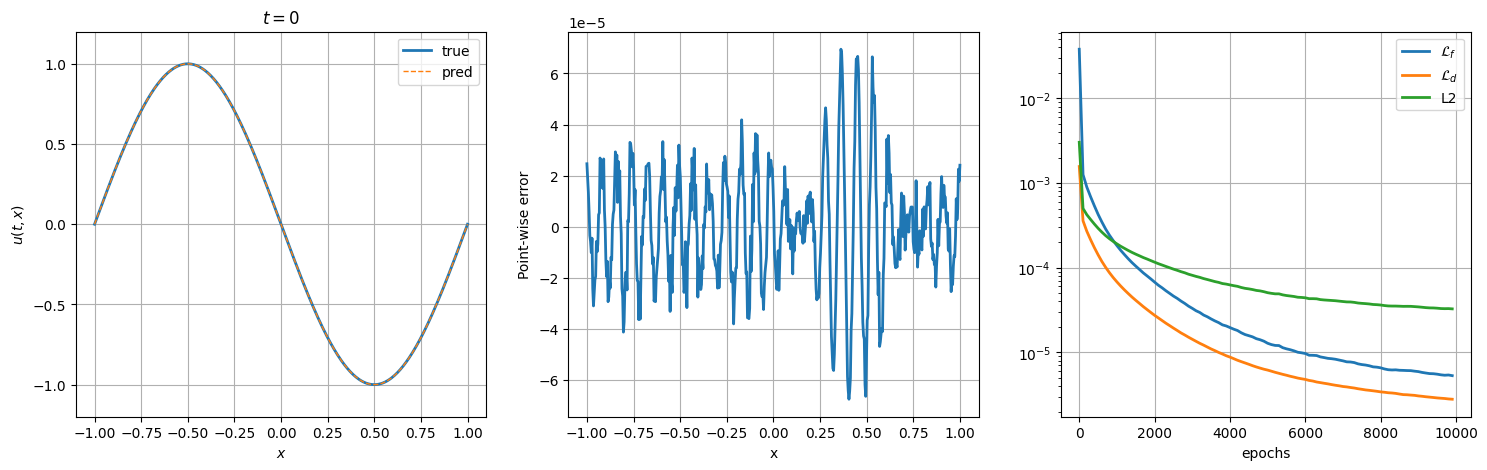

u0 training time: 26 s


In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
ax1.set_ylim(-1.2, 1.2)
ax1.plot(X_star, usol[:,0], label='true', linewidth=2)
ax1.plot(X_star, u_pred[0], label='pred', linewidth=1, linestyle='--')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$u(t, x)$')
ax1.set_title('$t = 0$')
ax1.legend()
ax1.grid(True)

ax2.ticklabel_format(style='sci', scilimits=(0, 0), axis='y')
ax2.plot(X_star, usol0- u_pred[0], linewidth=2)
ax2.set_xlabel('x')
ax2.set_ylabel('Point-wise error')
ax2.grid(True)

plt.yscale('log')
ax3.plot(100*np.arange(len(loss_f_log)), loss_f_log, label='$\mathcal{L}_{f}$', linewidth=2)
ax3.plot(100*np.arange(len(loss_d_log)), loss_d_log, label='$\mathcal{L}_{d}$', linewidth=2)
ax3.plot(100*np.arange(len(l2_error_log)), l2_error_log, label='L2', linewidth=2)
ax3.set_xlabel('epochs')
ax3.legend()
ax3.grid(True)
plt.show()

print('u0 training time: {:.0f} s'.format(elapsed_u0))

In [9]:
# Train u1 u2 u3 ...
start_time_rest = time.time()
print('Training u1 u2 u3 ...')

# logger
steps_each_tn_log = []
loss_k1_each_tn_log = []
loss_k2_each_tn_log = []
loss_r_each_tn_log = []
loss_k1_log = []
loss_k2_log = []
loss_r_log = []
loss_min_log = []

# New optimizer & schedule
schedule_u = optax.exponential_decay(init_value=1e-4, transition_steps=100, decay_rate=0.9)
schedule_k = optax.exponential_decay(init_value=1e-4, transition_steps=100, decay_rate=0.9)
optimizer_u = optax.adam(learning_rate=schedule_u)
optimizer_k = optax.adam(learning_rate=schedule_k)

# Train state
# state_u = train_state.TrainState.create(apply_fn=net_u.apply, params=params_u, tx=optimizer)
# state_k = train_state.TrainState.create(apply_fn=net_k.apply, params=params_k, tx=optimizer)

pbar = trange(1, N_t + 1, ncols=170)
for t_n in pbar:

    loss_last = 0
    loss_min = 1e8
    loss_patience = 0
    loss_k1_each_tn_log = []
    loss_k2_each_tn_log = []
    loss_r_each_tn_log = []

    # Use known Initial Condition when training u1
    if t_n == 1:
        uk, (duk_x, duk_xx, duk_xxx, duk_xxxx) = jet(U_x0, (X_r, ), [[1.0, 0.0, 0.0, 0.0]]) #  Taylor-mode AD
    else:
        uk_fn = lambda x: state_u.apply_fn(state_u.params, x)
        uk, (duk_x, duk_xx, duk_xxx, duk_xxxx) = jet(uk_fn, (X_r, ), [[1.0, 0.0, 0.0, 0.0]]) #  Taylor-mode AD
    
    # Renew train state
    # schedule_u = optax.exponential_decay(init_value=1e-4, transition_steps=100, decay_rate=0.95)
    # schedule_k = optax.exponential_decay(init_value=1e-4, transition_steps=100, decay_rate=0.95)
    # optimizer_u = optax.adam(learning_rate=schedule_u)
    # optimizer_k = optax.adam(learning_rate=schedule_k)
    state_u = train_state.TrainState.create(apply_fn=net_u.apply, params=state_u.params, tx=optimizer_u)
    state_k = train_state.TrainState.create(apply_fn=net_k.apply, params=state_k.params, tx=optimizer_k)
 
    for steps in range(1, 10000 + 1):
        state_u, state_k, loss_k1, loss_k2, loss_r = train_step_rest(state_u, state_k, X_r, uk, duk_x, duk_xx, duk_xxx, duk_xxxx, N_t)
        loss = loss_k1 + loss_k2 + loss_r
        pbar.set_postfix_str('steps:{:4d}, loss:{:.2e}, min:{:.2e}, k1:{:.2e}, k2:{:.2e}, r:{:.2e}, l2_last:{:.2e}'
                             .format(steps, loss, loss_min, loss_k1, loss_k2, loss_r, l2_each_tn_log[-1]))
        loss_k1_each_tn_log.append(loss_k1)
        loss_k2_each_tn_log.append(loss_k2)
        loss_r_each_tn_log.append(loss_r)

        # Save the best state
        if loss < loss_min:
            state_dict_u = flax.serialization.to_state_dict(state_u)
            state_dict_k = flax.serialization.to_state_dict(state_k)
            pickle.dump(state_dict_u, open('states/state_u{:d}.pkl'.format(t_n), 'wb'))
            pickle.dump(state_dict_k, open('states/state_k{:d}.pkl'.format(t_n), 'wb'))
            loss_min = loss 
            loss_patience = steps

        # Determine whether to proceed to the next time step
        if steps>300 and (0<loss_last-loss<=1e-10 or steps-loss_patience>500):
            break
        loss_last = loss
        
    # Load the best state
    pkl_file_u = pickle.load(open('states/state_u{:d}.pkl'.format(t_n), 'rb'))
    pkl_file_k = pickle.load(open('states/state_k{:d}.pkl'.format(t_n), 'rb'))
    state_u = flax.serialization.from_state_dict(state_u, pkl_file_u)
    state_k = flax.serialization.from_state_dict(state_k, pkl_file_k)
    if t_n % dtdt == 0:
        u_pred.append(state_u.apply_fn(state_u.params, X_star))
        t_index = int(t_n/dtdt)
        usol_tn = usol[:,t_index:t_index+1]
        l2_each_tn_log.append(jnp.linalg.norm(usol_tn - u_pred[-1]) / jnp.linalg.norm(usol_tn))

    # Log 
    steps_each_tn_log.append(steps)
    loss_min_log.append(loss_min)
    loss_k1_log.append(loss_k1_each_tn_log)
    loss_k2_log.append(loss_k2_each_tn_log)
    loss_r_log.append(loss_r_each_tn_log)

elapsed_rest = time.time() - start_time_rest

Training u1 u2 u3 ...


100%|████████████████████████████████| 250/250 [1:25:44<00:00, 20.58s/it, steps:2925, loss:1.09e-03, min:1.01e-03, k1:3.79e-04, k2:3.37e-04, r:3.75e-04, l2_last:1.17e-01]


In [10]:
# Save data
path = 'result_rk'
pickle.dump(u_pred, open(f'{path}/u_pred.pkl', 'wb'))
pickle.dump(loss_k1_log, open(f'{path}/loss_k1.pkl', 'wb'))
pickle.dump(loss_k2_log, open(f'{path}/loss_k2.pkl', 'wb'))
pickle.dump(loss_r_log, open(f'{path}/loss_r.pkl', 'wb'))
pickle.dump(loss_min_log, open(f'{path}/loss_min.pkl', 'wb'))
pickle.dump(l2_each_tn_log, open(f'{path}/l2_each_tn.pkl', 'wb'))
pickle.dump(steps_each_tn_log, open(f'{path}/steps_each_tn.pkl', 'wb'))

In [11]:
# Load data
# u_pred = pickle.load(open(f'{path}/u_pred.pkl', 'rb'))
# loss_k1_log = pickle.load(open(f'{path}/loss_k1.pkl', 'rb'))
# loss_k2_log = pickle.load(open(f'{path}/loss_k2.pkl', 'rb'))
# loss_r_log = pickle.load(open(f'{path}/loss_r.pkl', 'rb'))
# loss_min_log = pickle.load(open(f'{path}/loss_min.pkl', 'rb'))
# l2_each_tn_log = pickle.load(open(f'{path}/l2_each_tn.pkl', 'rb'))
# steps_each_tn_log = pickle.load(open(f'{path}/steps_each_tn.pkl', 'rb'))

In [12]:
# Load states, predict, compute L2 error
# schedule = optax.exponential_decay(init_value=1e-3, transition_steps=100, decay_rate=0.9)
# optimizer = optax.adam(learning_rate=schedule)
# state_u = train_state.TrainState.create(apply_fn=net_u.apply, params=params_u, tx=optimizer)
# state_k = train_state.TrainState.create(apply_fn=net_k.apply, params=params_k, tx=optimizer)
# l2_each_tn_log = []
# u_pred = []
# for t_n in range(0, N_t+1):
#     if t_n % dtdt == 0:
#         pkl_file_u = pickle.load(open('states/state_u{:d}.pkl'.format(t_n), 'rb'))
#         pkl_file_k = pickle.load(open('states/state_k{:d}.pkl'.format(t_n), 'rb'))
#         state_u = flax.serialization.from_state_dict(state_u, pkl_file_u)
#         state_k = flax.serialization.from_state_dict(state_k, pkl_file_k)

#         u_pred.append(state_u.apply_fn(state_u.params, X_star))
#         t_index = int(t_n/dtdt)
#         usol_tn = usol[:,t_index:t_index+1]
#         l2_each_tn_log.append(jnp.linalg.norm(usol_tn - u_pred[-1]) / jnp.linalg.norm(usol_tn))
# print(len(l2_each_tn_log))
# print(len(u_pred))

In [13]:
u_pred_copy = copy.deepcopy(u_pred)

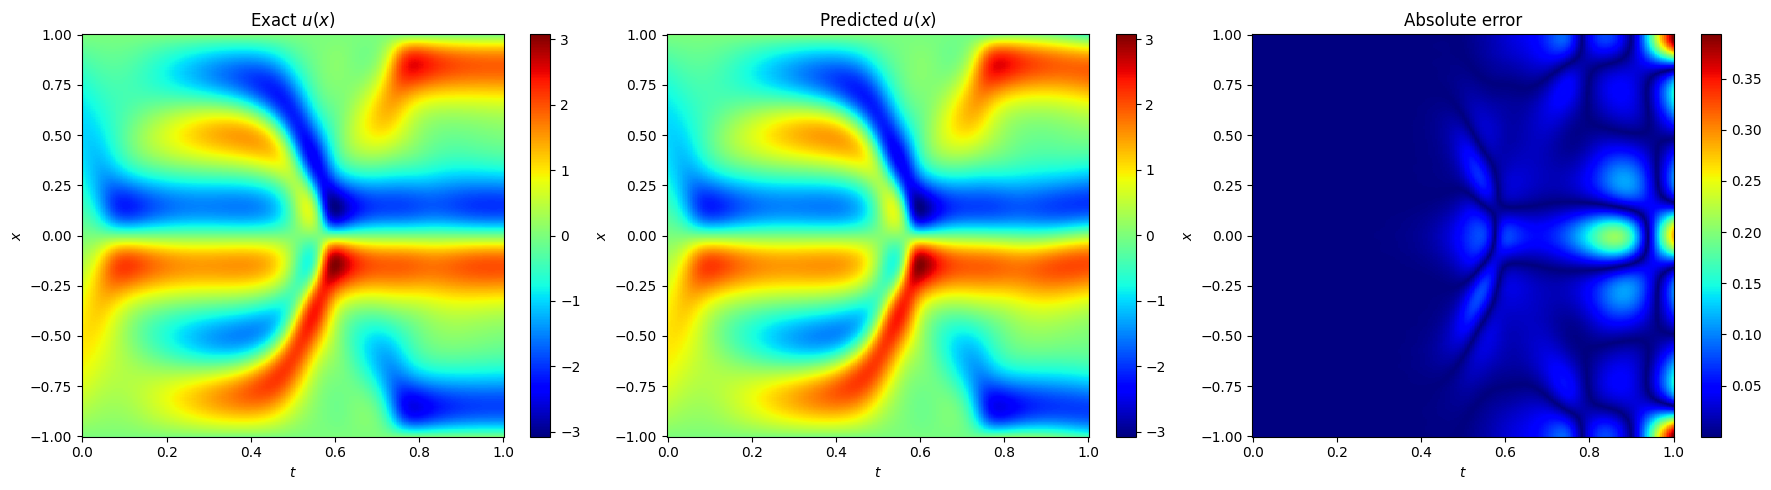

L2 error = 3.55023e-02
training time after u0: 5145 s
total time: 5171 s


In [14]:
# Reshape to the same format & compute L2 error
u_pred = copy.deepcopy(u_pred_copy)
u_pred = np.reshape(u_pred, (len(usol[0]), len(usol))).T
l2_error = np.linalg.norm(usol - u_pred) / np.linalg.norm(usol)

fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(TT, XX, usol, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Exact $u(x)$')
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.pcolor(TT, XX, u_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Predicted $u(x)$')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.pcolor(TT, XX, np.abs(usol - u_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()

plt.show()

print('L2 error = {:.5e}'.format(l2_error))
print('training time after u0: {:.0f} s'.format(elapsed_rest))
print('total time: {:.0f} s'.format(elapsed_u0+elapsed_rest))

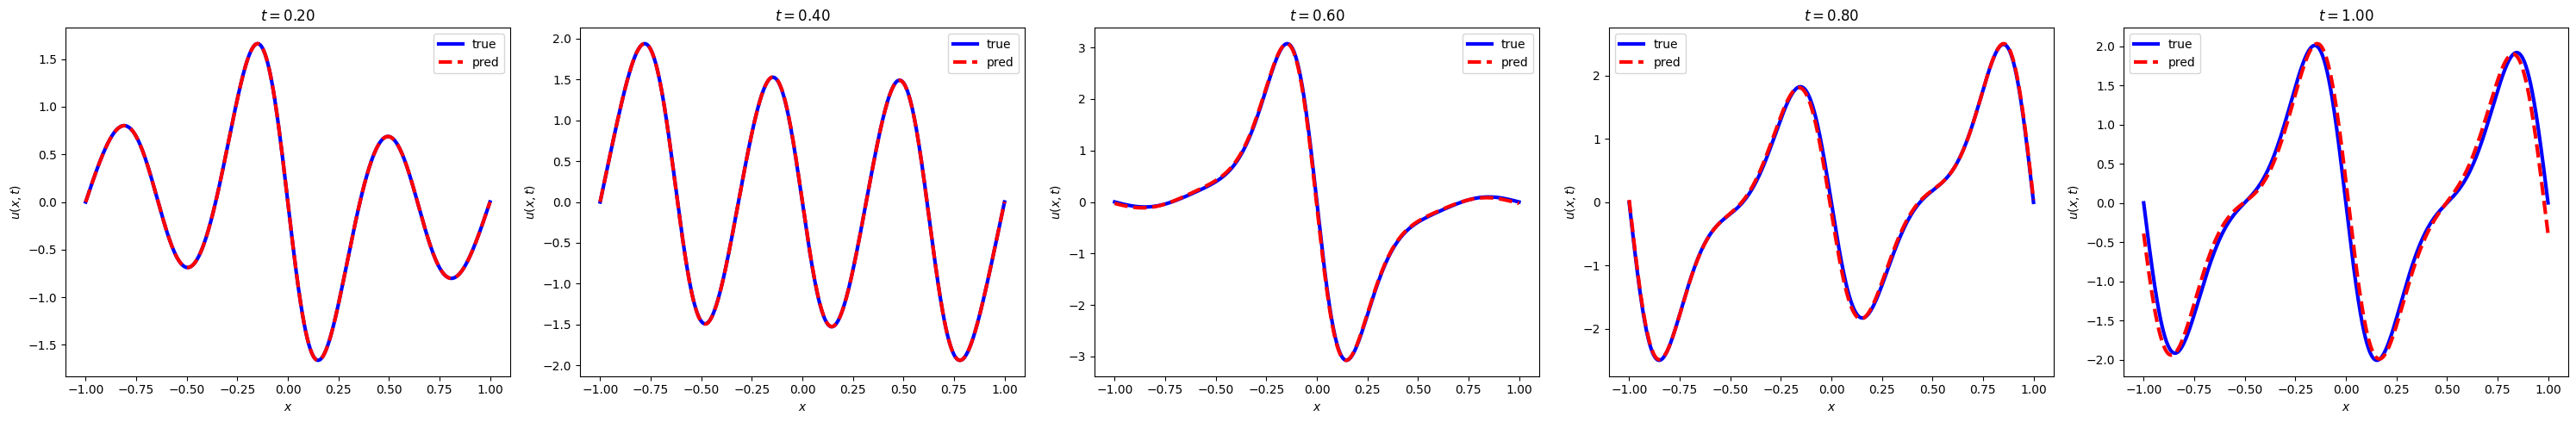

In [15]:
# point wise plot of several time stamps
fig = plt.figure(figsize=(30, 5))
plt.subplot(1, 5, 1)
plt.plot(X_r, usol[:, 50:51], label='true', color='blue', linestyle='-', linewidth=3)
plt.plot(X_r, u_pred[:, 50:51], label='pred', color='red', linestyle='--', linewidth=3)
plt.xlabel('$x$')
plt.ylabel('$u(x, t)$')
plt.title(r'$t=0.20$')
plt.legend()
plt.tight_layout()

plt.subplot(1, 5, 2)
plt.plot(X_r, usol[:, 100:101], label='true', color='blue', linestyle='-', linewidth=3)
plt.plot(X_r, u_pred[:, 100:101], label='pred', color='red', linestyle='--', linewidth=3)
plt.xlabel('$x$')
plt.ylabel('$u(x, t)$')
plt.title(r'$t=0.40$')
plt.legend()
plt.tight_layout()

plt.subplot(1, 5, 3)
plt.plot(X_r, usol[:, 150:151], label='true', color='blue', linestyle='-', linewidth=3)
plt.plot(X_r, u_pred[:, 150:151], label='pred', color='red', linestyle='--', linewidth=3)
plt.xlabel('$x$')
plt.ylabel('$u(x, t)$')
plt.title(r'$t=0.60$')
plt.legend()
plt.tight_layout()

plt.subplot(1, 5, 4)
plt.plot(X_r, usol[:, 200:201], label='true', color='blue', linestyle='-', linewidth=3)
plt.plot(X_r, u_pred[:, 200:201], label='pred', color='red', linestyle='--', linewidth=3)
plt.xlabel('$x$')
plt.ylabel('$u(x, t)$')
plt.title(r'$t=0.80$')
plt.legend()
plt.tight_layout()

plt.subplot(1, 5, 5)
plt.plot(X_r, usol[:, 250:], label='true', color='blue', linestyle='-', linewidth=3)
plt.plot(X_r, u_pred[:, 250:], label='pred', color='red', linestyle='--', linewidth=3)
plt.xlabel('$x$')
plt.ylabel('$u(x, t)$')
plt.title(r'$t=1.00$')
plt.legend()
plt.tight_layout()

plt.show()

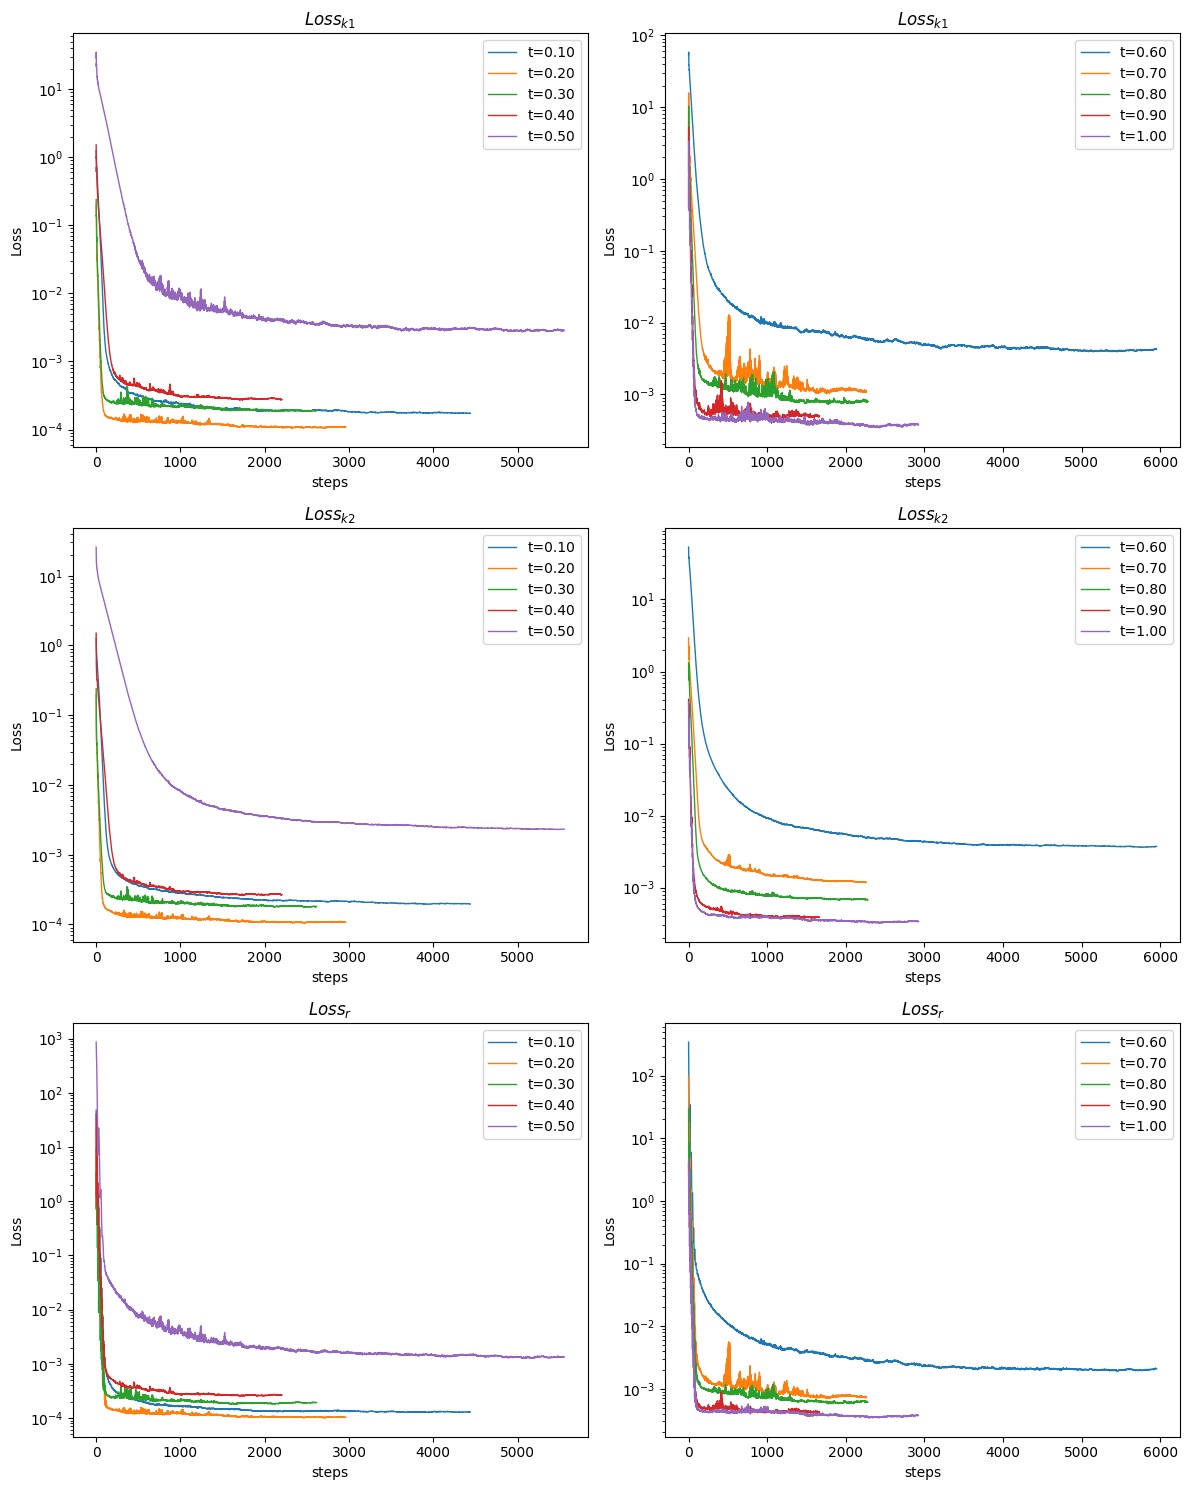

In [16]:
# Loss values of several time stamps
loss_k1_plot = loss_k1_log[25*dtdt-1::dtdt*25]
loss_k2_plot = loss_k2_log[25*dtdt-1::dtdt*25]
loss_r_plot = loss_r_log[25*dtdt-1::dtdt*25]

fig = plt.figure(figsize=(12, 15))
plt.subplot(3, 2, 1)
plt.yscale('log')
for t in range(0, 5):
    plt.plot(np.arange(len(loss_k1_plot[t])), loss_k1_plot[t], label='t={:.2f}'.format((t+1)/10), linewidth=1)
plt.xlabel('steps')
plt.ylabel('Loss')
plt.title('$Loss_{k1}$')
plt.legend()
plt.tight_layout()

plt.subplot(3, 2, 2)
plt.yscale('log')
for t in range(5, 10):
    plt.plot(np.arange(len(loss_k1_plot[t])), loss_k1_plot[t], label='t={:.2f}'.format((t+1)/10), linewidth=1)
plt.xlabel('steps')
plt.ylabel('Loss')
plt.title('$Loss_{k1}$')
plt.legend()
plt.tight_layout()

plt.subplot(3, 2, 3)
plt.yscale('log')
for t in range(0, 5):
    plt.plot(np.arange(len(loss_k2_plot[t])), loss_k2_plot[t], label='t={:.2f}'.format((t+1)/10), linewidth=1)
plt.xlabel('steps')
plt.ylabel('Loss')
plt.title('$Loss_{k2}$')
plt.legend()
plt.tight_layout()

plt.subplot(3, 2, 4)
plt.yscale('log')
for t in range(5, 10):
    plt.plot(np.arange(len(loss_k2_plot[t])), loss_k2_plot[t], label='t={:.2f}'.format((t+1)/10), linewidth=1)
plt.xlabel('steps')
plt.ylabel('Loss')
plt.title('$Loss_{k2}$')
plt.legend()
plt.tight_layout()

plt.subplot(3, 2, 5)
plt.yscale('log')
for t in range(0, 5):
    plt.plot(np.arange(len(loss_r_plot[t])), loss_r_plot[t], label='t={:.2f}'.format((t+1)/10), linewidth=1)
plt.xlabel('steps')
plt.ylabel('Loss')
plt.title('$Loss_{r}$')
plt.legend()
plt.tight_layout()

plt.subplot(3, 2, 6)
plt.yscale('log')
for t in range(5, 10):
    plt.plot(np.arange(len(loss_r_plot[t])), loss_r_plot[t], label='t={:.2f}'.format((t+1)/10), linewidth=1)
plt.xlabel('steps')
plt.ylabel('Loss')
plt.title('$Loss_{r}$')
plt.legend()
plt.tight_layout()

plt.show()

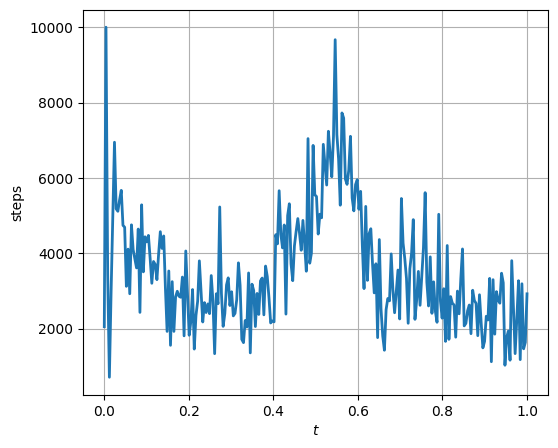

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
# plt.yscale('log')
ax.plot(np.linspace(0, 1, len(steps_each_tn_log)), steps_each_tn_log, linewidth=2)
ax.set_xlabel('$t$')
ax.set_ylabel('steps')
# ax.set_title('steps each t_n')
ax.grid(True)
plt.show()

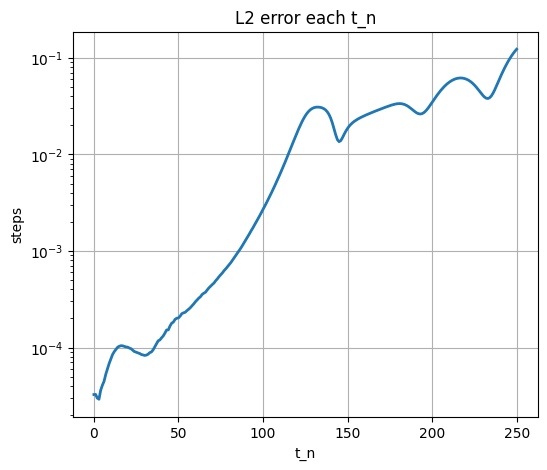

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plt.yscale('log')
ax.plot(np.arange(len(l2_each_tn_log)), l2_each_tn_log, linewidth=2)
ax.set_xlabel('t_n')
ax.set_ylabel('steps')
ax.set_title('L2 error each t_n')
ax.grid(True)
plt.show()

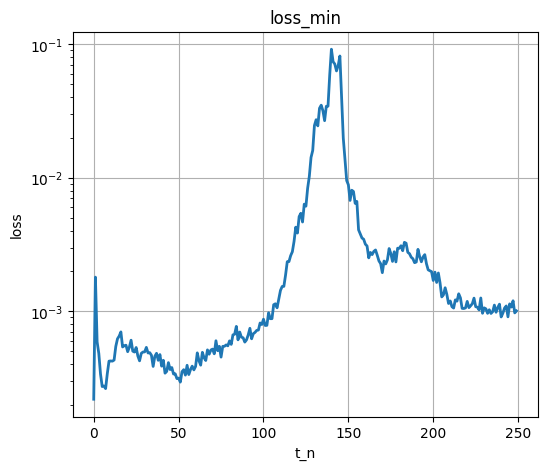

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plt.yscale('log')
ax.plot(np.arange(len(loss_min_log)), loss_min_log, linewidth=2)
ax.set_xlabel('t_n')
ax.set_ylabel('loss')
ax.set_title('loss_min')
ax.grid(True)
plt.show()